In [ ]:
#upload from the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd

# Load the datset
file_path = "/content/drive/MyDrive/waqi-covid19-airqualitydata-2025.csv"
df = pd.read_csv(file_path, skiprows=4)

In [ ]:
# 1. Check for missing values
missing_values = df.isnull().sum()

# 2. Number of unique cities and species
unique_cities = df['City'].nunique()
unique_species = df['Specie'].nunique()

# 3. Summary statistics for numerical columns
summary_statistics = df.describe()

missing_values, unique_cities, unique_species, summary_statistics

(Date        0
 Country     0
 City        0
 Specie      0
 count       0
 min         0
 max         0
 median      0
 variance    0
 dtype: int64,
 579,
 19,
               count           min           max        median      variance
 count  2.239883e+06  2.239883e+06  2.239883e+06  2.239883e+06  2.239883e+06
 mean   1.211374e+02  1.095859e+02  1.363832e+02  1.200932e+02  2.520228e+03
 std    1.801446e+02  2.942985e+02  2.968207e+02  2.947167e+02  4.995299e+04
 min    2.000000e+00 -3.273900e+03 -6.420000e+01 -7.600000e+01  0.000000e+00
 25%    3.700000e+01  1.000000e+00  9.500000e+00  4.000000e+00  1.753500e+01
 50%    7.200000e+01  5.000000e+00  2.600000e+01  1.400000e+01  9.608000e+01
 75%    1.440000e+02  2.450000e+01  8.200000e+01  4.780000e+01  6.413150e+02
 max    2.616000e+03  1.100000e+03  3.275100e+03  1.301800e+03  3.550800e+07)

#Exploratory Analysis
We will investigate the distributions of key air quality metrics, focusing on:

Understanding extreme values and possible outliers.
Distribution of species and their statistics.
City-wise and specie-wise grouping.

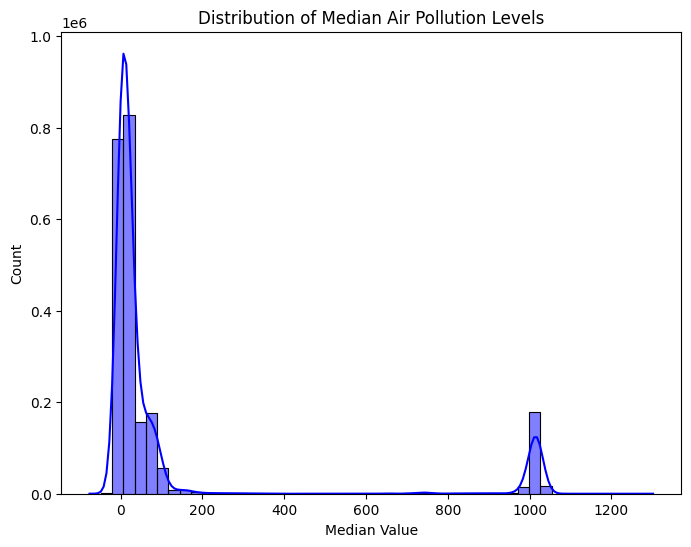

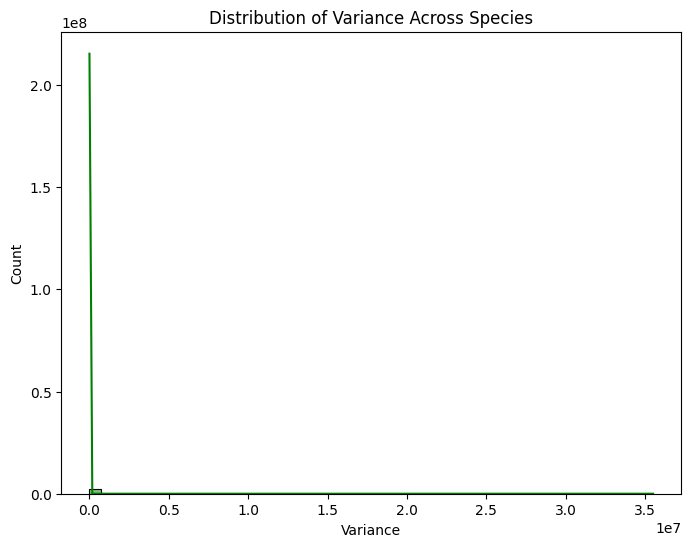

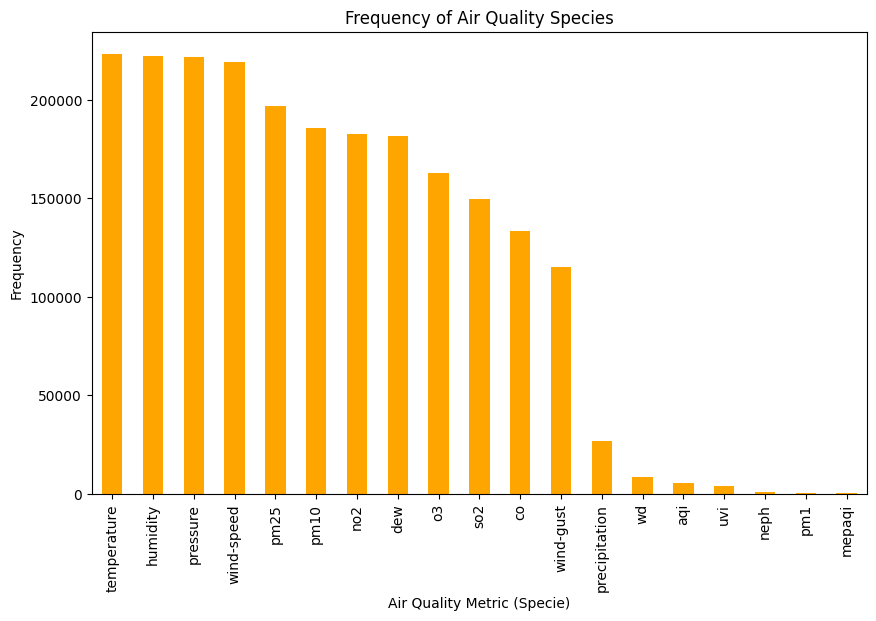

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Distribution of the median air pollution levels
plt.figure(figsize=(8, 6))
sns.histplot(df['median'], bins=50, kde=True, color='blue')
plt.title("Distribution of Median Air Pollution Levels")
plt.xlabel("Median Value")
plt.show()

# 2. Check the distribution of variance to identify cities with high fluctuations
plt.figure(figsize=(8, 6))
sns.histplot(df['variance'], bins=50, kde=True, color='green')
plt.title("Distribution of Variance Across Species")
plt.xlabel("Variance")
plt.show()

# 3. Distribution of air quality species
plt.figure(figsize=(10, 6))
df['Specie'].value_counts().plot(kind='bar', color='orange')
plt.title("Frequency of Air Quality Species")
plt.xlabel("Air Quality Metric (Specie)")
plt.ylabel("Frequency")
plt.show()

#Key Observations and Next Steps
Based on the visualizations:

Distribution of median values:

Most air pollution metrics have a low median, concentrated near 0 to 200. However, there are outliers exceeding 1,000, indicating cities or dates with extreme pollution conditions that need further exploration.
Variance distribution:

The variance distribution is heavily skewed, with most of the data having low variance, but some cases show extreme values (up to
3.5
×
10
7
3.5×10
7
 ). This could indicate inconsistent readings or high variability in specific cities or species.
Species distribution:

Air quality metrics like temperature, humidity, pressure, wind speed, PM2.5, and PM10 have the highest representation in the data. Metrics like PM1, uv index, and neph have lower counts, suggesting they may not be available for all cities or periods.

#Outlier Analysis
We need to detect outliers and identify their potential impact on clustering. We will use the Interquartile Range (IQR) method to flag outliers in key columns like min, max, median, and variance.

In [ ]:
# Function to detect outliers using IQR
def detect_outliers(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Detecting outliers in key columns
outliers_min = detect_outliers('min')
outliers_max = detect_outliers('max')
outliers_median = detect_outliers('median')
outliers_variance = detect_outliers('variance')

# Display the number of outliers in each column
len(outliers_min), len(outliers_max), len(outliers_median), len(outliers_variance)

(331085, 248649, 246935, 315396)

#Handling Outliers
We have a significant number of outliers detected in the key columns:

min: 331,085 outliers
max: 248,649 outliers
median: 246,935 outliers
variance: 315,396 outliers
These outliers could influence clustering results, potentially leading to improper segmentation of cities. We have two options:

Cap or remove outliers to limit their influence on clustering.
Keep the outliers and let the clustering algorithm account for them.

#Remove Extreme Outliers
We will use the IQR bounds to filter out extreme values for the columns of interest.

In [ ]:
# Function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out outliers
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply the outlier removal for key columns
cleaned_df = remove_outliers(df, 'min')
cleaned_df = remove_outliers(cleaned_df, 'max')
cleaned_df = remove_outliers(cleaned_df, 'median')
cleaned_df = remove_outliers(cleaned_df, 'variance')

# Check the new size of the cleaned dataset
cleaned_size = cleaned_df.shape
cleaned_size

(1424671, 9)

#Aggregation and Pivoting
This step aggregates the median values of air pollution metrics (species) for each city and pivots the data so that each city becomes a row, with species as columns.

In [ ]:
# 1. Aggregate the mean of the 'median' values for each city and species over all days
city_species_agg = cleaned_df.groupby(['City', 'Specie']).agg({
    'median': 'mean'
}).reset_index()

# 2. Pivot the data so that each species becomes a feature column
pivot_aqi_df = city_species_agg.pivot(index='City', columns='Specie', values='median')

In [ ]:
pivot_aqi_df.shape, pivot_aqi_df.head(1000)

((579, 18),
 Specie     aqi         co        dew   humidity  mepaqi  neph        no2  \
 City                                                                       
 Abidjan    NaN        NaN  24.960432        NaN     NaN   NaN        NaN   
 Abu Dhabi  NaN   0.100000  18.942462  44.625000     NaN   NaN  11.500917   
 Accra      NaN        NaN  23.998071        NaN     NaN   NaN        NaN   
 Adana      NaN   5.758364  12.494472  32.714286     NaN   NaN  26.357143   
 Adapazarı  NaN  11.597313   9.954408  43.700000     NaN   NaN  13.847679   
 ...        ...        ...        ...        ...     ...   ...        ...   
 İzmir      NaN   8.357143   9.044584  36.350000     NaN   NaN   9.131933   
 İzmit      NaN  11.625552   9.769521        NaN     NaN   NaN  12.230573   
 Łódź       NaN   0.100000   5.789848  42.700000     NaN   NaN   6.739276   
 Ōita       NaN   3.048813  12.139000  48.100000     NaN   NaN   4.281500   
 Ḩawallī    NaN   6.516923        NaN  35.810072     NaN   NaN  

In [ ]:
# Drop columns with all NaN values
pivot_aqi_df = pivot_aqi_df.drop(columns=['aqi', 'mepaqi', 'neph', 'pm1', 'wd', 'uvi'])

# Check the new shape and preview
pivot_aqi_df.shape, pivot_aqi_df.head(1000)

((579, 12),
 Specie            co        dew   humidity        no2         o3       pm10  \
 City                                                                          
 Abidjan          NaN  24.960432        NaN        NaN        NaN        NaN   
 Abu Dhabi   0.100000  18.942462  44.625000  11.500917  24.751351  32.000000   
 Accra            NaN  23.998071        NaN        NaN        NaN        NaN   
 Adana       5.758364  12.494472  32.714286  26.357143  10.530496  22.769231   
 Adapazarı  11.597313   9.954408  43.700000  13.847679  13.560729  25.197674   
 ...              ...        ...        ...        ...        ...        ...   
 İzmir       8.357143   9.044584  36.350000   9.131933  15.771090  23.343915   
 İzmit      11.625552   9.769521        NaN  12.230573  15.583984  25.709402   
 Łódź        0.100000   5.789848  42.700000   6.739276  19.026690  16.430000   
 Ōita        3.048813  12.139000  48.100000   4.281500  23.578365  11.193370   
 Ḩawallī     6.516923       

In [ ]:
# Drop irrelevant columns
columns_to_drop = ['dew', 'humidity', 'precipitation', 'temperature', 'wind-gust', 'wind-speed']
pivot_aqi_df = pivot_aqi_df.drop(columns=columns_to_drop)

# Check the resulting DataFrame
pivot_aqi_df.shape, pivot_aqi_df.head()

((579, 6),
 Specie            co        no2         o3       pm10       pm25       so2
 City                                                                      
 Abidjan          NaN        NaN        NaN        NaN  18.000000       NaN
 Abu Dhabi   0.100000  11.500917  24.751351  32.000000        NaN  5.220479
 Accra            NaN        NaN        NaN        NaN  24.600000       NaN
 Adana       5.758364  26.357143  10.530496  22.769231  31.928571  2.968712
 Adapazarı  11.597313  13.847679  13.560729  25.197674  44.542857  6.084839)

#Code to Drop Cities with NaN Values

In [ ]:
# Drop cities with any NaN values
pivot_aqi_df = pivot_aqi_df.dropna()

# Check the resulting shape and preview the data
pivot_aqi_df.shape, pivot_aqi_df.head()

((215, 6),
 Specie                 co        no2         o3       pm10       pm25  \
 City                                                                    
 Adana            5.758364  26.357143  10.530496  22.769231  31.928571   
 Adapazarı       11.597313  13.847679  13.560729  25.197674  44.542857   
 Adelaide         2.097878   2.438422   8.948346  13.604895  16.919192   
 Aguascalientes   3.093000   4.740110   5.377949  14.650000  13.000000   
 Akita            2.715818   4.368672  27.158993   8.737401  23.666667   
 
 Specie                so2  
 City                       
 Adana            2.968712  
 Adapazarı        6.084839  
 Adelaide         0.684821  
 Aguascalientes  16.697849  
 Akita            2.120115  )

In [ ]:
# Save the cleaned dataset to a CSV file
pivot_aqi_df.to_csv('cleaned_air_quality_data.csv', index=True)

print("Data saved as cleaned_air_quality_data.csv")

Data saved as cleaned_air_quality_data.csv


#Deriving insights from the cleaned dataset using EDA

In [ ]:
#%% [code]
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Enable inline plotting in Colab
%matplotlib inline

# Load the already-cleaned dataset
df = pd.read_csv('cleaned_air_quality_data.csv')

# Inspect the first few rows and summary statistics
print("Dataset Head:")
print(df.head(), "\n")
print("Dataset Info:")
print(df.info(), "\n")
print("Summary Statistics:")
print(df.describe())

Dataset Head:
             City         co        no2         o3       pm10       pm25  \
0           Adana   5.758364  26.357143  10.530496  22.769231  31.928571   
1       Adapazarı  11.597313  13.847679  13.560729  25.197674  44.542857   
2        Adelaide   2.097878   2.438422   8.948346  13.604895  16.919192   
3  Aguascalientes   3.093000   4.740110   5.377949  14.650000  13.000000   
4           Akita   2.715818   4.368672  27.158993   8.737401  23.666667   

         so2  
0   2.968712  
1   6.084839  
2   0.684821  
3  16.697849  
4   2.120115   

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   City    215 non-null    object 
 1   co      215 non-null    float64
 2   no2     215 non-null    float64
 3   o3      215 non-null    float64
 4   pm10    215 non-null    float64
 5   pm25    215 non-null    float64
 6   so2     215 non-nu

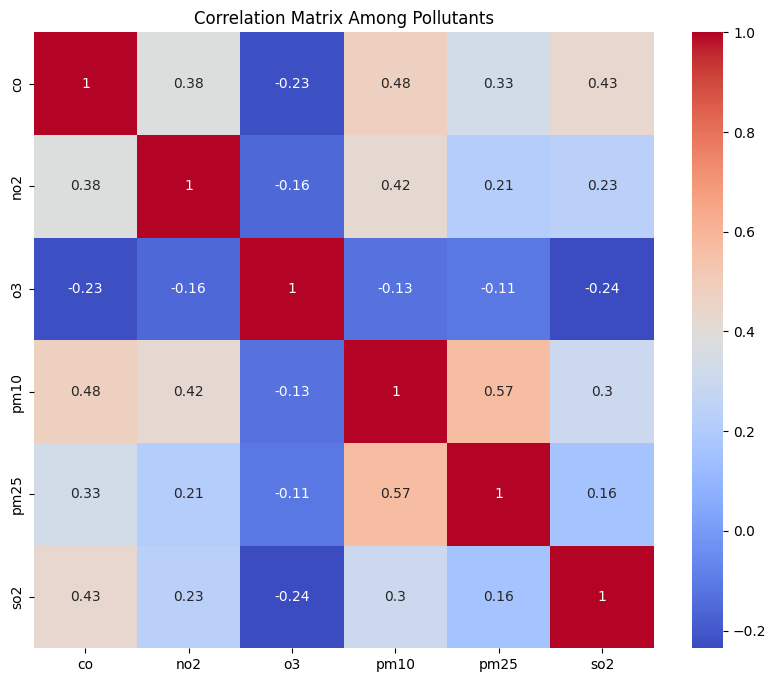

In [ ]:
#%% [code]
# Define pollutant columns for easier use
pollutants = ['co', 'no2', 'o3', 'pm10', 'pm25', 'so2']

# Plot correlation matrix among pollutants
plt.figure(figsize=(10,8))
sns.heatmap(df[pollutants].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix Among Pollutants")
plt.show()

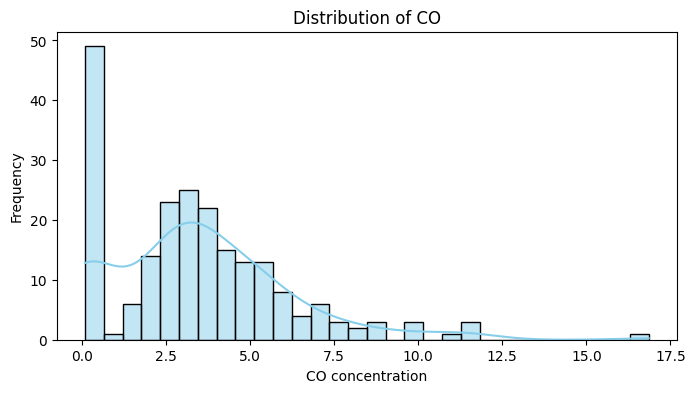

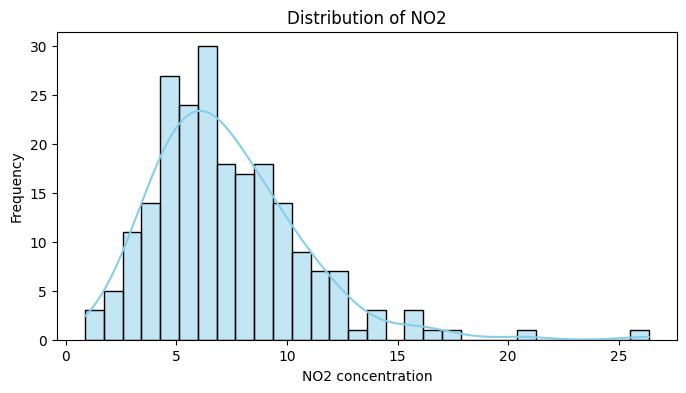

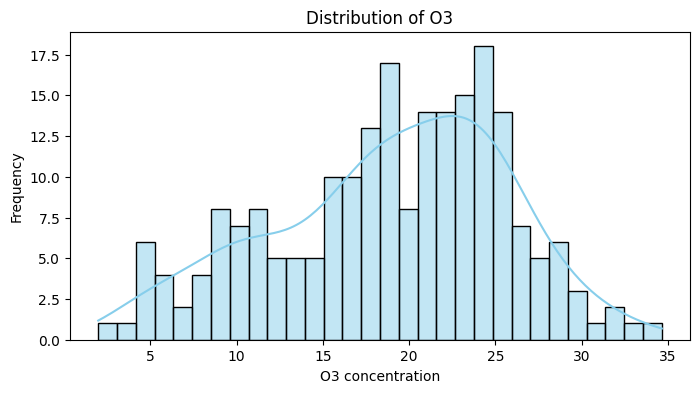

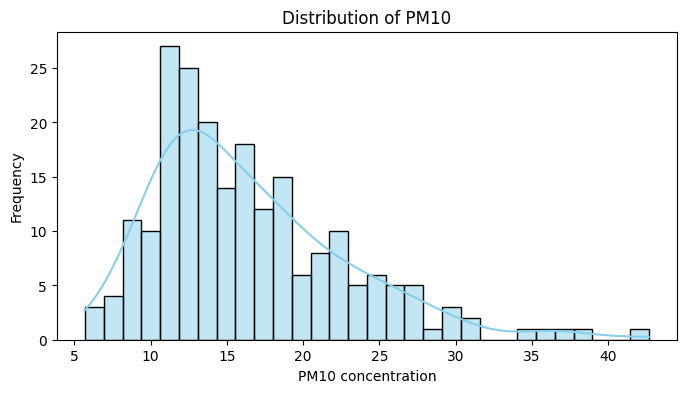

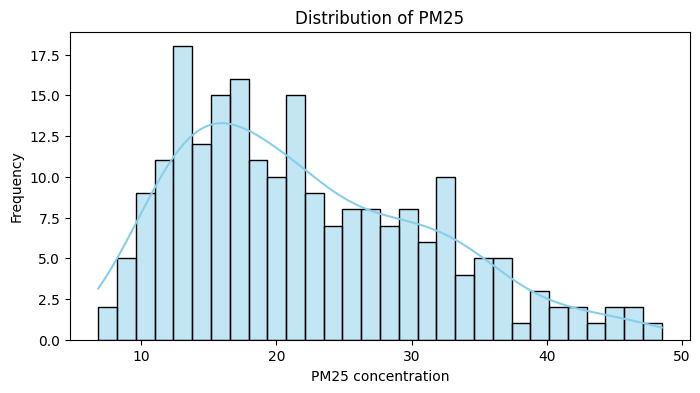

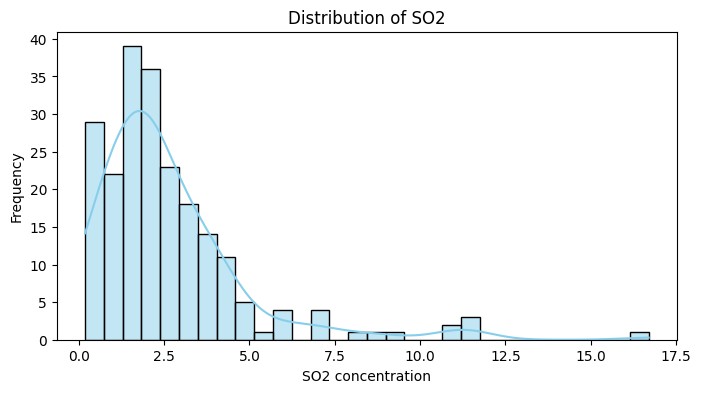

In [ ]:
#%% [code]
# Plot Distribution and Kernel Density Estimate (KDE) for each pollutant
for col in pollutants:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f"Distribution of {col.upper()}")
    plt.xlabel(f"{col.upper()} concentration")
    plt.ylabel("Frequency")
    plt.show()

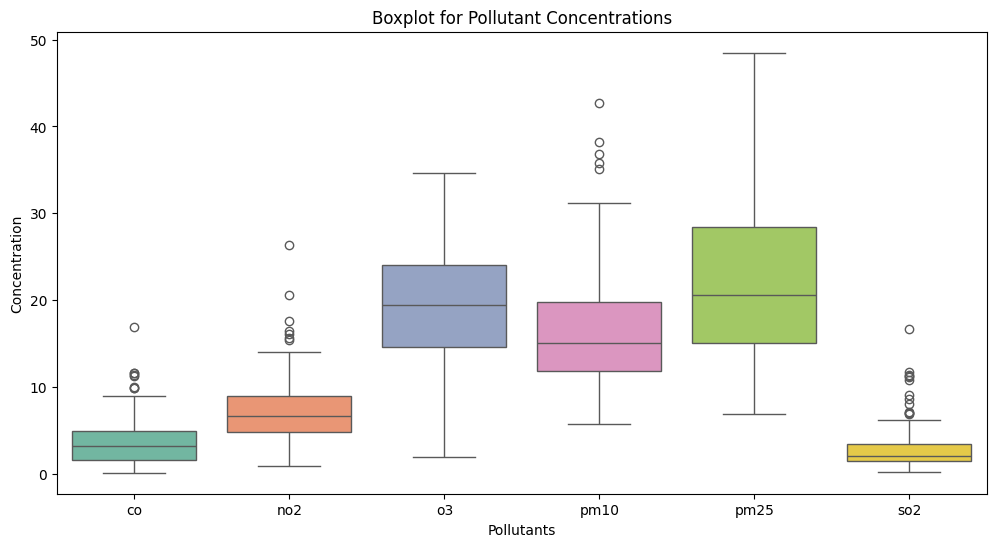

In [ ]:
#%% [code]
# Boxplots for the pollutant data to visualize spread and outliers
plt.figure(figsize=(12,6))
sns.boxplot(data=df[pollutants], palette="Set2")
plt.title("Boxplot for Pollutant Concentrations")
plt.xlabel("Pollutants")
plt.ylabel("Concentration")
plt.show()

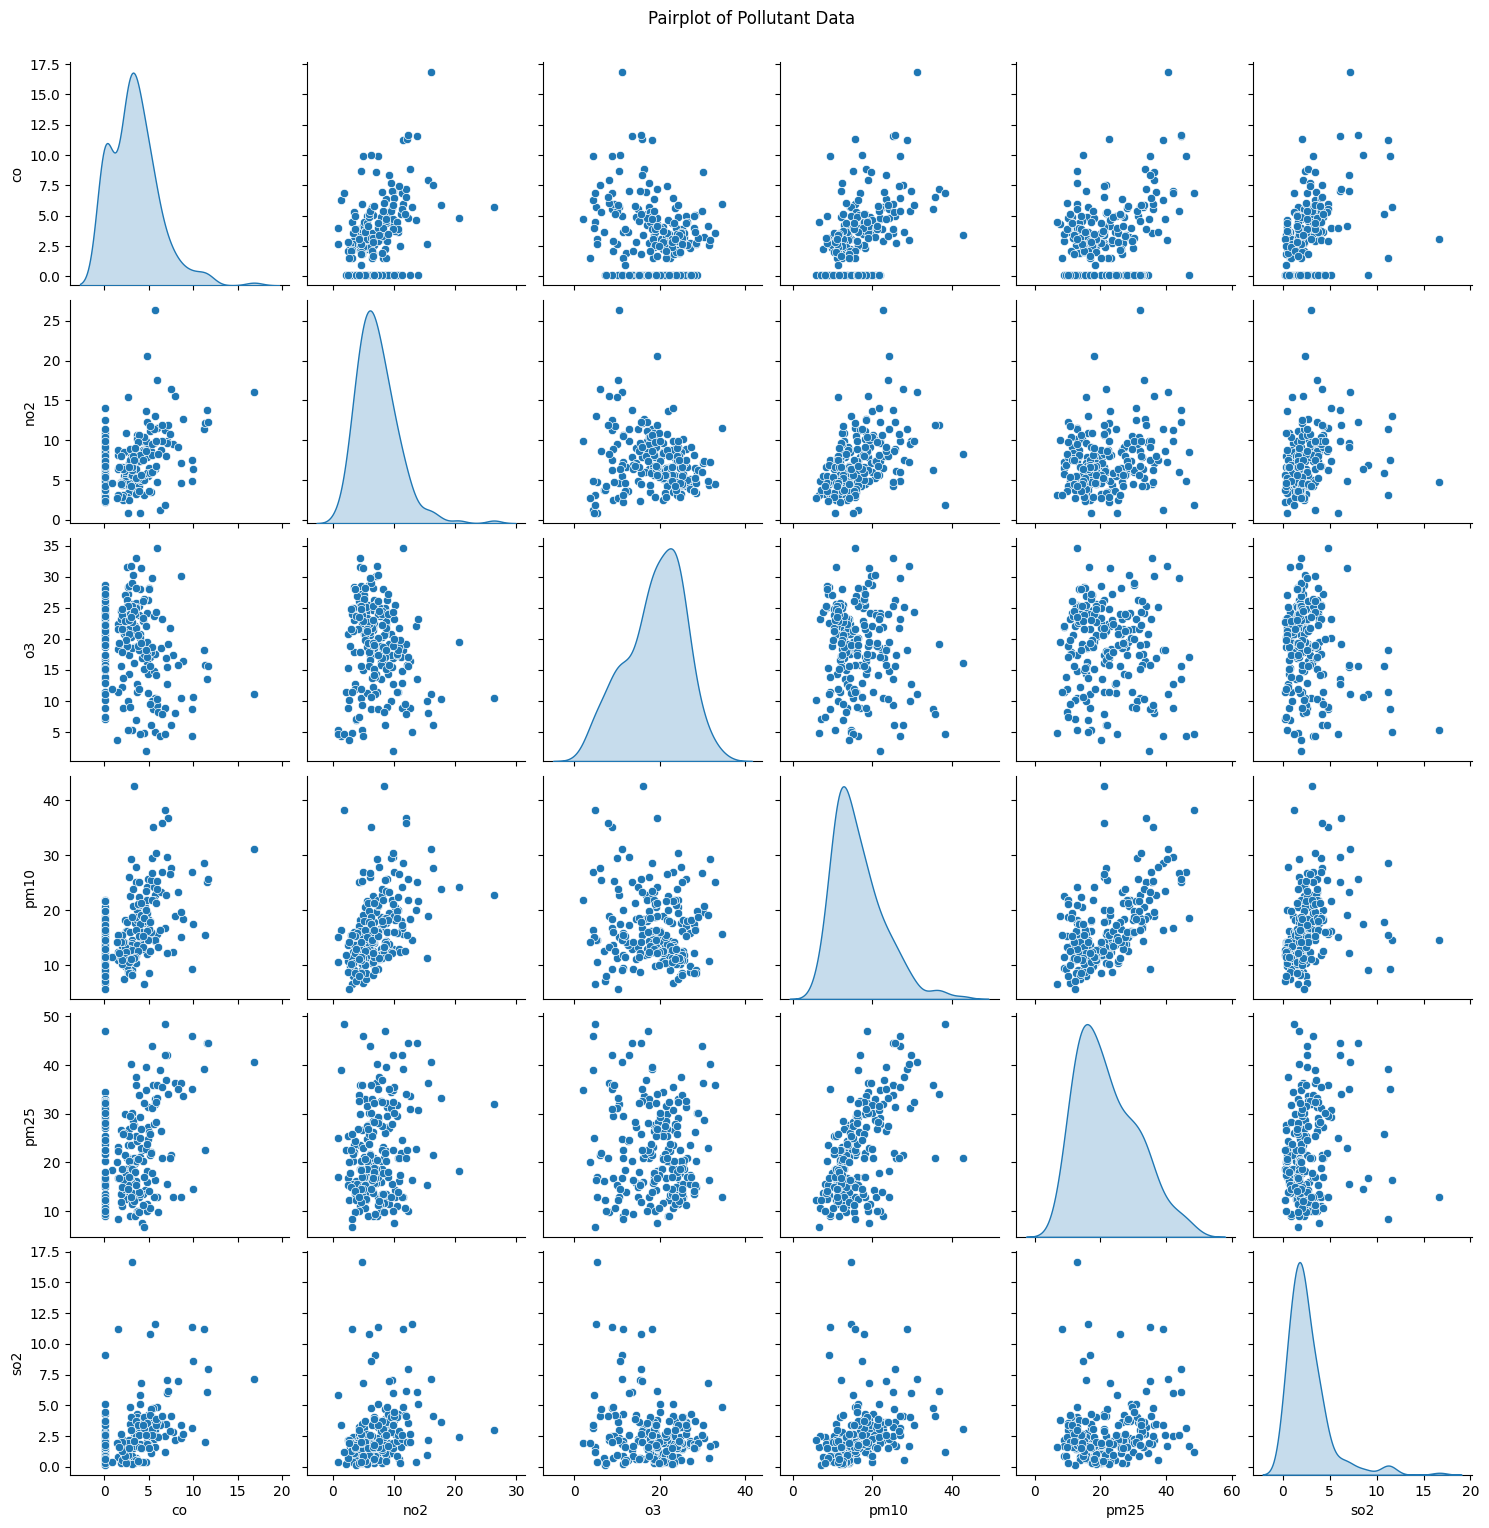

In [ ]:
#%% [code]
# Pairplot to visualize pairwise relationships among pollutants
sns.pairplot(df[pollutants], diag_kind='kde', height=2.5)
plt.suptitle("Pairplot of Pollutant Data", y=1.02)
plt.show()

<ipython-input-27-d56d28066261>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="pollution_index", y="City", data=top_cities, palette='Reds_r')


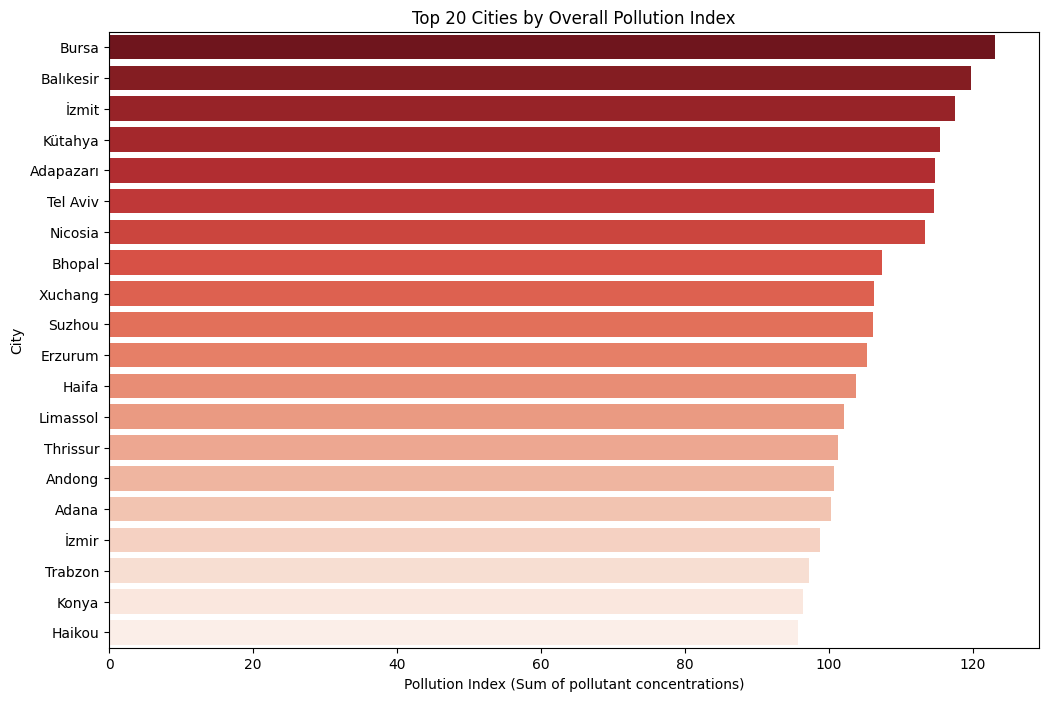

In [ ]:
#%% [code]
# Create an overall Pollution Index by summing pollutant values per city.
# (This index is a rough proxy to gauge overall pollution level.)
df['pollution_index'] = df[pollutants].sum(axis=1)

# Bar chart of the top 20 cities (highest pollution index)
top_cities = df.sort_values('pollution_index', ascending=False).head(20)
plt.figure(figsize=(12,8))
sns.barplot(x="pollution_index", y="City", data=top_cities, palette='Reds_r')
plt.title("Top 20 Cities by Overall Pollution Index")
plt.xlabel("Pollution Index (Sum of pollutant concentrations)")
plt.ylabel("City")
plt.show()

In [ ]:
#%% [code]
# -------------------------------
# Clustering using KMeans to identify "critical clusters"
# -------------------------------

# Extract pollutant features
X = df[pollutants]

# Apply KMeans clustering; here we choose 3 clusters (adjust n_clusters as needed)
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Calculate the average pollutant concentration for each cluster
cluster_means = df.groupby('cluster')[pollutants].mean()
cluster_avg = cluster_means.mean(axis=1)
print("Cluster Averages (mean pollutant levels):")
print(cluster_avg, "\n")

# Identify the cluster with the highest overall pollution average (critical cluster)
critical_cluster = cluster_avg.idxmax()
print(f"Critical cluster (highest average pollution): {critical_cluster}")

# List cities belonging to the critical cluster
critical_cluster_cities = df[df['cluster'] == critical_cluster]
print("\nCities in the critical cluster:")
print(critical_cluster_cities[['City','pollution_index']])

Cluster Averages (mean pollutant levels):
cluster
0    16.137173
1     9.857418
2    12.963091
dtype: float64 

Critical cluster (highest average pollution): 0

Cities in the critical cluster:
             City  pollution_index
0           Adana       100.312517
1       Adapazarı       114.831092
8          Ankara        89.030836
10      Balıkesir       119.727567
16         Bhopal       107.455126
25          Bursa       123.090358
33        Chennai        95.299075
39     Cuernavaca        92.710391
51          Dubai        94.629660
75       Istanbul        88.420675
80   Johannesburg        75.222970
85        Kayseri        83.665089
90          Konya        96.395554
94        Kütahya       115.418466
97       Limassol       102.133591
113       Morelia        81.827031
115        Murcia        93.086257
120        Nagpur        72.272700
122       Nanning        95.180302
125        Nashik        83.746785
126       Nicosia       113.389145
140      Pretoria        70.891170
15

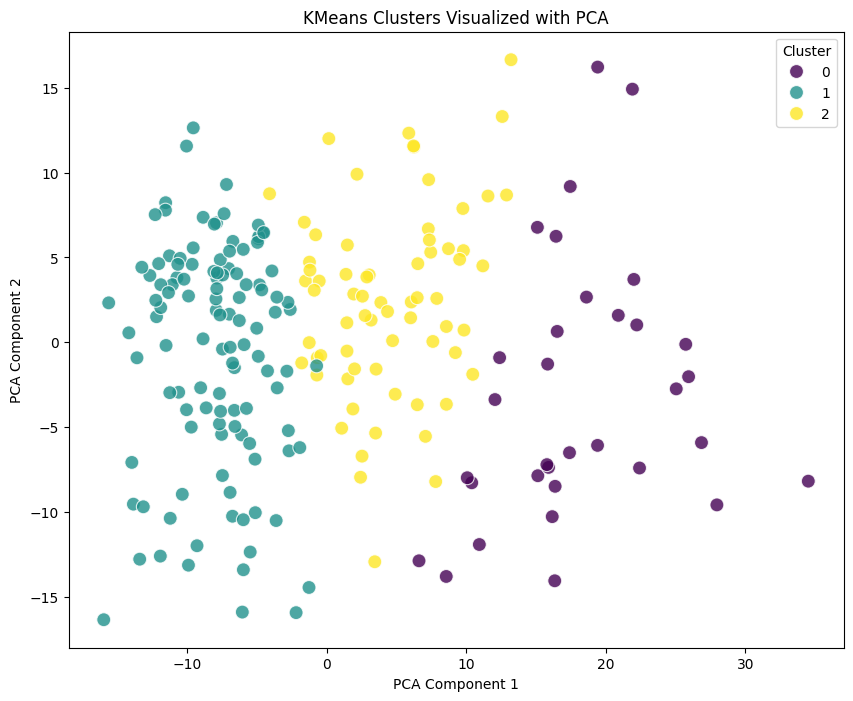

In [ ]:
#%% [code]
# Visualize clusters using PCA for 2D projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df['pca1'] = X_pca[:, 0]
df['pca2'] = X_pca[:, 1]

plt.figure(figsize=(10,8))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=df, palette='viridis', s=100, alpha=0.8)
plt.title("KMeans Clusters Visualized with PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.show()

<ipython-input-30-57a303b7e20d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y="pollution_index", data=df, palette="Pastel1")


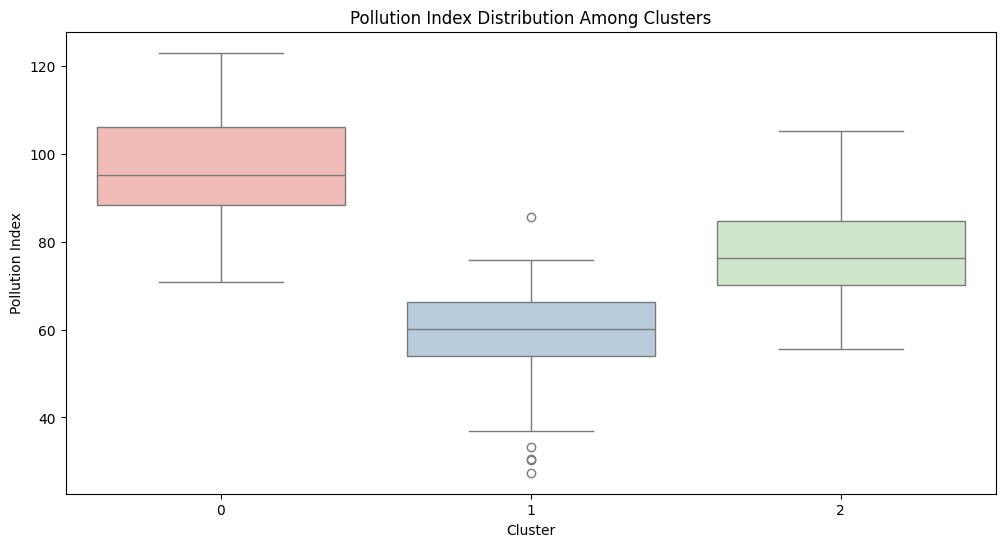

In [ ]:
#%% [code]
# Compare the distribution of the pollution index across clusters
plt.figure(figsize=(12,6))
sns.boxplot(x="cluster", y="pollution_index", data=df, palette="Pastel1")
plt.title("Pollution Index Distribution Among Clusters")
plt.xlabel("Cluster")
plt.ylabel("Pollution Index")
plt.show()

#Clustering Using Scikit-Learn

In [ ]:
# Extract numeric features
X = df[pollutants].values

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
df['sk_kmeans_cluster'] = kmeans.fit_predict(X)

# Display cluster average pollutant values
kmeans_means = df.groupby('sk_kmeans_cluster')[pollutants].mean()
print("KMeans Cluster Averages:")
print(kmeans_means)

KMeans Cluster Averages:
                         co        no2         o3       pm10       pm25  \
sk_kmeans_cluster                                                         
0                  6.754346  10.232334  13.462507  26.076313  36.168408   
1                  2.738580   6.354323  19.600122  13.064003  15.100571   
2                  2.928936   7.351100  20.351541  17.455447  27.172291   

                        so2  
sk_kmeans_cluster            
0                  4.129131  
1                  2.286907  
2                  2.519228  


In [ ]:
from sklearn.cluster import DBSCAN

# (Adjust eps and min_samples as needed for your data.)
dbscan = DBSCAN(eps=5, min_samples=2)
df['sk_dbscan_cluster'] = dbscan.fit_predict(X)

# Exclude noise points (-1) when computing cluster averages
if -1 in df['sk_dbscan_cluster'].unique():
    dbscan_means = df[df['sk_dbscan_cluster'] != -1].groupby('sk_dbscan_cluster')[pollutants].mean()
else:
    dbscan_means = df.groupby('sk_dbscan_cluster')[pollutants].mean()

print("DBSCAN Cluster Averages:")
print(dbscan_means)

DBSCAN Cluster Averages:
                          co        no2         o3       pm10       pm25  \
sk_dbscan_cluster                                                          
0                  11.611433  13.039126  14.572357  25.453538  44.504762   
1                   2.298579   6.109863  21.484837  13.596329  20.006677   
2                   5.370830   7.895518  14.262798  19.890249  27.801948   
3                   0.100000   7.048193  12.587902   9.394485   9.189590   
4                   4.501186  10.098025  18.100678  20.933506  11.981481   
5                   5.273403   7.210046  18.910724  22.277222  26.660714   
6                   1.047340  10.671242   9.836392  16.781560  29.999548   
7                   6.691641   8.596359  16.928631  23.224710  37.262222   
8                   0.100000   3.587210   8.259686   6.924727  11.565500   
9                   6.165249   9.908780  23.778125  28.689895  33.916667   
10                  5.617582  10.059384   8.907866  12.891667  

In [ ]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=3)
df['sk_agg_cluster'] = agg.fit_predict(X)

agg_means = df.groupby('sk_agg_cluster')[pollutants].mean()
print("Agglomerative Cluster Averages:")
print(agg_means)

Agglomerative Cluster Averages:
                      co        no2         o3       pm10       pm25       so2
sk_agg_cluster                                                                
0               2.789284   6.288200  19.425949  13.168323  15.808570  2.250381
1               3.275774   8.135685  20.364534  19.957983  28.506110  2.754334
2               7.598588  10.216545  10.913570  24.459233  39.035501  4.615692


In [ ]:
!pip install tensorflow tensorflow_probability

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

# Convert data to TensorFlow tensor (float32)
X_tf = tf.convert_to_tensor(X, dtype=tf.float32)
num_components = 3
num_features = len(pollutants)

# Initialize parameters for the GMM
weights = tf.Variable(tf.ones([num_components]) / num_components, dtype=tf.float32, name="weights")
initial_means = X[np.random.choice(X.shape[0], num_components, replace=False)]
means = tf.Variable(initial_means, dtype=tf.float32, name="means")
initial_scale = tf.eye(num_features, batch_shape=[num_components])
scale_tril = tf.Variable(initial_scale, dtype=tf.float32, name="scale_tril")

def build_gmm():
    return tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=weights),
        components_distribution=tfd.MultivariateNormalTriL(
            loc=means,
            scale_tril=scale_tril
        )
    )

# Training loop
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
for step in range(300):
    with tf.GradientTape() as tape:
        gmm = build_gmm()
        loss = -tf.reduce_mean(gmm.log_prob(X_tf))
    grads = tape.gradient(loss, [weights, means, scale_tril])
    optimizer.apply_gradients(zip(grads, [weights, means, scale_tril]))
    if step % 50 == 0:
        print(f"Step {step}: NLL = {loss.numpy():.3f}")

# After training, assign clusters by choosing the component with maximum probability
gmm = build_gmm()  # rebuild updated GMM
probs = tf.stack([
    tfd.MultivariateNormalTriL(loc=means[i], scale_tril=scale_tril[i]).prob(X_tf)
    for i in range(num_components)
], axis=1)
tfp_clusters = tf.argmax(probs, axis=1).numpy()
df['tfp_gmm_cluster'] = tfp_clusters

print("TFP GMM cluster assignments (first 5 rows):")
print(df[['City', 'tfp_gmm_cluster']].head())

Step 0: NLL = 97.584
Step 50: NLL = 22.165
Step 100: NLL = 19.466
Step 150: NLL = 18.357
Step 200: NLL = 17.650
Step 250: NLL = 17.226
TFP GMM cluster assignments (first 5 rows):
             City  tfp_gmm_cluster
0           Adana                2
1       Adapazarı                1
2        Adelaide                2
3  Aguascalientes                0
4           Akita                2


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple 1D SOM module
class SOM(nn.Module):
    def __init__(self, m, n, dim):
        super(SOM, self).__init__()
        self.m = m  # grid height
        self.n = n  # grid width (here, 1D map so n=1)
        self.dim = dim  # input dimensionality
        # Initialize neuron weight vectors (m*n x dim)
        self.weights = nn.Parameter(torch.randn(m * n, dim))

    def forward(self, x):
        # x: [batch, dim]
        x_exp = x.unsqueeze(1)          # [batch, 1, dim]
        weights_exp = self.weights.unsqueeze(0)  # [1, m*n, dim]
        distances = torch.norm(x_exp - weights_exp, dim=2)  # [batch, m*n]
        bmu_indices = distances.argmin(dim=1)
        return bmu_indices

# Settings: Use a 1D SOM with 3 neurons and feature dimension = number of pollutants
m, n = 3, 1
dim = len(pollutants)
som = SOM(m, n, dim)
optimizer_som = optim.Adam(som.parameters(), lr=0.05)
X_tensor = torch.tensor(X, dtype=torch.float32)

# Train SOM for 100 epochs
num_epochs = 100
for epoch in range(num_epochs):
    optimizer_som.zero_grad()
    bmu_indices = som(X_tensor)
    # Loss: Mean distance of each sample to its Best Matching Unit (BMU)
    distances = torch.cdist(X_tensor, som.weights)
    loss = distances.min(dim=1)[0].mean()
    loss.backward()
    optimizer_som.step()
    if epoch % 20 == 0:
        print(f"SOM Epoch {epoch}: Loss = {loss.item():.3f}")

# Obtain cluster assignments from SOM
pt_som_clusters = som(X_tensor).numpy()
df['pt_som_cluster'] = pt_som_clusters

print("PyTorch SOM cluster assignments (first 5 rows):")
print(df[['City', 'pt_som_cluster']].head())

SOM Epoch 0: Loss = 34.821
SOM Epoch 20: Loss = 32.888
SOM Epoch 40: Loss = 30.840
SOM Epoch 60: Loss = 28.102
SOM Epoch 80: Loss = 25.702
PyTorch SOM cluster assignments (first 5 rows):
             City  pt_som_cluster
0           Adana               1
1       Adapazarı               1
2        Adelaide               1
3  Aguascalientes               1
4           Akita               1


Epoch 0: Reconstruction Loss = 232.614
Epoch 20: Reconstruction Loss = 31.461
Epoch 40: Reconstruction Loss = 21.353
Epoch 60: Reconstruction Loss = 17.788
Epoch 80: Reconstruction Loss = 13.755
Epoch 100: Reconstruction Loss = 10.037
Epoch 120: Reconstruction Loss = 8.187
Epoch 140: Reconstruction Loss = 7.727
Epoch 160: Reconstruction Loss = 7.493
Epoch 180: Reconstruction Loss = 7.339


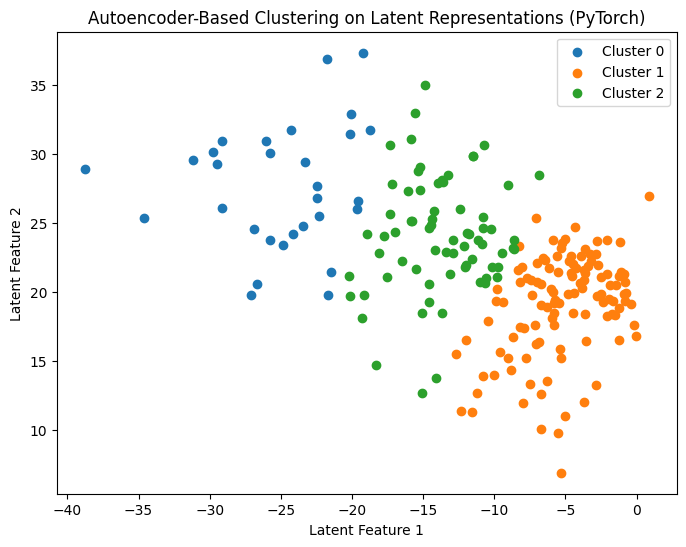

PyTorch Autoencoder-based cluster assignments (first 5 rows):
             City  pt_ae_cluster
0           Adana              0
1       Adapazarı              0
2        Adelaide              1
3  Aguascalientes              1
4           Akita              1


In [ ]:
import torch.nn as nn
import torch.optim as optim

# Define a simple autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return z, x_recon

input_dim = len(pollutants)
latent_dim = 2  # Compress to 2D for visualization and clustering
ae = Autoencoder(input_dim, latent_dim)
optimizer_ae = optim.Adam(ae.parameters(), lr=0.01)
criterion = nn.MSELoss()

X_pt = torch.tensor(X, dtype=torch.float32)
num_epochs_ae = 200
for epoch in range(num_epochs_ae):
    optimizer_ae.zero_grad()
    z, x_recon = ae(X_pt)
    loss = criterion(x_recon, X_pt)
    loss.backward()
    optimizer_ae.step()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Reconstruction Loss = {loss.item():.3f}")

# Obtain latent representations
with torch.no_grad():
    latent_features, _ = ae(X_pt)
latent_np = latent_features.numpy()

# Define a simple PyTorch-based k-means (operating on the latent space)
def pytorch_kmeans(data, num_clusters=3, num_iters=100):
    data_tensor = torch.tensor(data, dtype=torch.float32)
    n_samples = data_tensor.size(0)
    # Randomly choose initial centers
    indices = torch.randperm(n_samples)[:num_clusters]
    centers = data_tensor[indices]
    for i in range(num_iters):
        distances = torch.cdist(data_tensor, centers)
        labels = torch.argmin(distances, dim=1)
        new_centers = torch.stack([data_tensor[labels==k].mean(dim=0) for k in range(num_clusters)])
        if torch.allclose(new_centers, centers, rtol=1e-4, atol=1e-4):
            break
        centers = new_centers
    return labels, centers

pt_ae_labels, _ = pytorch_kmeans(latent_np, num_clusters=3, num_iters=100)
df['pt_ae_cluster'] = pt_ae_labels.numpy()

# (Optional) Visualize the latent space and clusters
plt.figure(figsize=(8, 6))
for k in range(3):
    cluster_data = latent_np[pt_ae_labels==k]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f"Cluster {k}")
plt.xlabel("Latent Feature 1")
plt.ylabel("Latent Feature 2")
plt.title("Autoencoder-Based Clustering on Latent Representations (PyTorch)")
plt.legend()
plt.show()

print("PyTorch Autoencoder-based cluster assignments (first 5 rows):")
print(df[['City', 'pt_ae_cluster']].head())

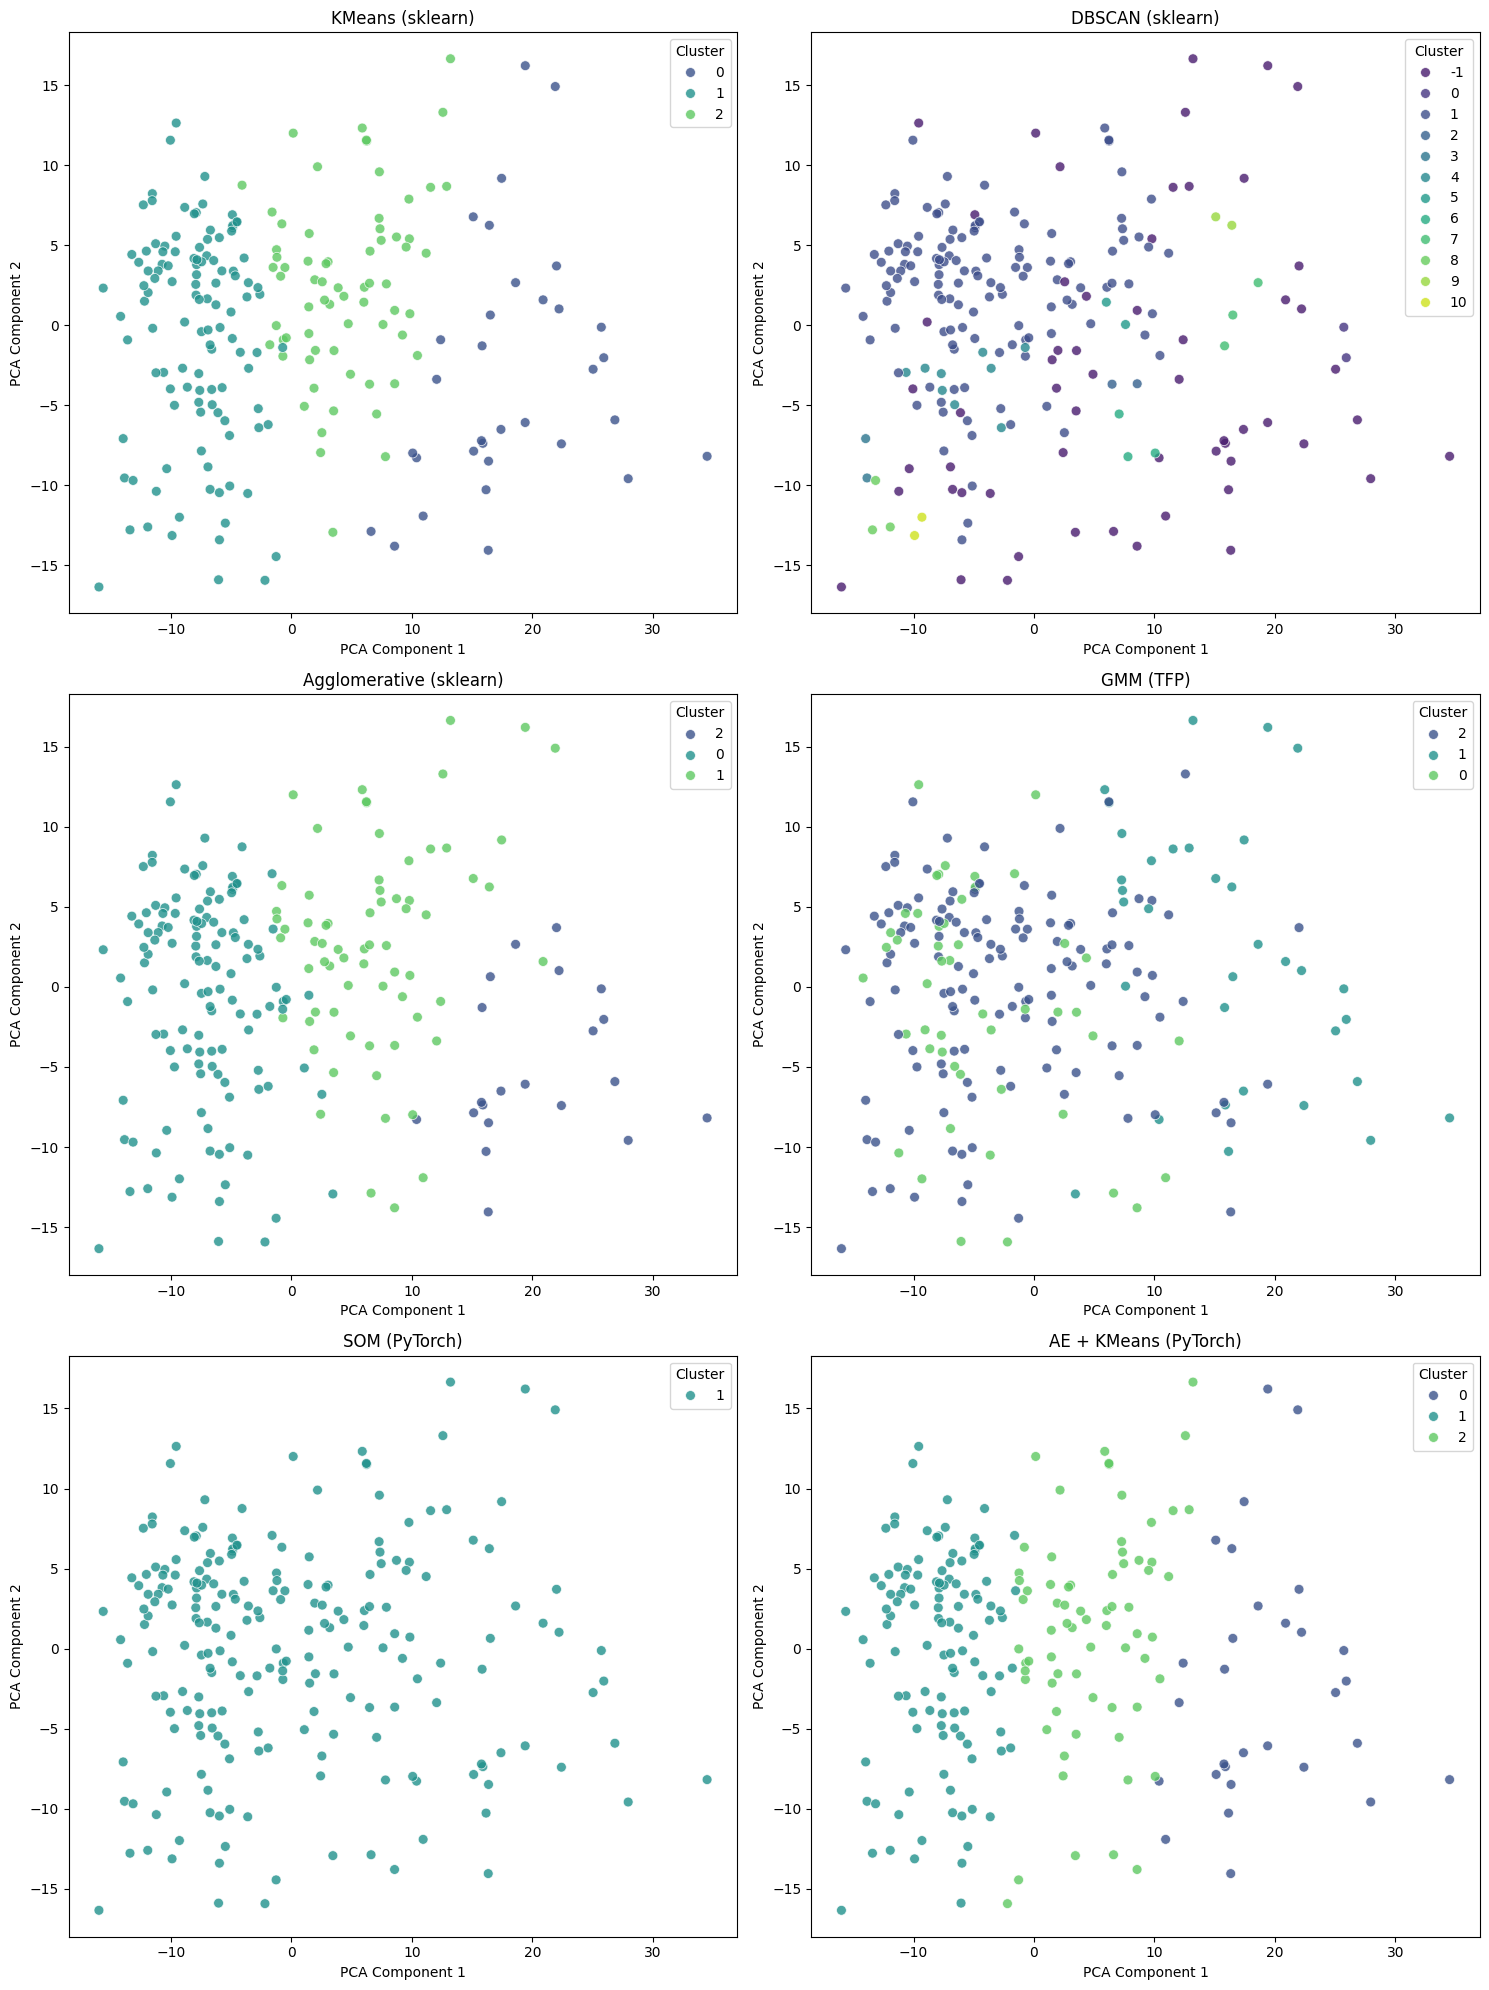

In [ ]:
from sklearn.decomposition import PCA

# Run PCA on the original pollutant features
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Dictionary mapping method name to the DataFrame column with its labels
cluster_methods = {
    'KMeans (sklearn)': 'sk_kmeans_cluster',
    'DBSCAN (sklearn)': 'sk_dbscan_cluster',
    'Agglomerative (sklearn)': 'sk_agg_cluster',
    'GMM (TFP)': 'tfp_gmm_cluster',
    'SOM (PyTorch)': 'pt_som_cluster',
    'AE + KMeans (PyTorch)': 'pt_ae_cluster'
}

plt.figure(figsize=(15, 20))
for i, (title, col_name) in enumerate(cluster_methods.items(), start=1):
    plt.subplot(3, 2, i)
    sns.scatterplot(
        x=X_pca[:, 0], y=X_pca[:, 1],
        hue=df[col_name].astype(str),  # convert labels to str for discrete coloring
        palette='viridis', s=50, alpha=0.8
    )
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(title)
    plt.legend(title='Cluster', loc='best')
plt.tight_layout()
plt.show()